In [0]:
import numpy as np
import tensorflow as tf
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from IPython import display
import sys
from matplotlib import pyplot as plt

In [0]:
class ANN_Model(object):
    """
      Define conv1d model for time series analysis of gas mixtures 
      hidden_layers_numeber : layers number       
      filter_per_size : filter size of each layers, list [layers_number,]
      split_layer : the layer we split the shared layer into two layers
      split_regularizer : the layer we switch a different regularizer
      regularizers : two different regularizers
      
    """
    def __init__(self,hidden_layers_number,
                 filters_per_size,split_layer,split_regularizer,regularizers):
        
        self._inputs = tf.placeholder(tf.float32,
                                      shape=[None, None, 16],
                                      name='inputs')
        
        self.hidden_layers_number = hidden_layers_number
        self.filters_per_size = filters_per_size
        self.split_layer = split_layer
        self.regularizers = []
        for i in range(hidden_layers_number):
            if (split_regularizer>i+1):
                self.regularizers.append(regularizers[0])
            else:
                self.regularizers.append(regularizers[1])
        
        
    def _Ann(self):
        
        """
           The first parts share the same features, the second parts learn separate features. 
           
        """
        Input_1 = self._inputs
        for i in range(hidden_layers_number):
            if self.split_layer>i+1:
                Output = tf.layers.Dense(units = self.filters_per_size[i],
                                         activation=tf.nn.selu,kernel_regularizer=self.regularizers[i])(Input_1)
                Input_1 = Output
                Input_2 = Output
            else:
                if i<hidden_layers_number-1:
                    Output_1 = tf.layers.Dense(units = self.filters_per_size[i],
                                         activation=tf.nn.selu,kernel_regularizer=self.regularizers[i])(Input_1)
                    Output_2 = tf.layers.Dense(units = self.filters_per_size[i],
                                         activation=tf.nn.selu,kernel_regularizer=self.regularizers[i])(Input_2)
                else:
                    Output_1 = tf.layers.Dense(units = self.filters_per_size[i],
                                         activation=None,kernel_regularizer=self.regularizers[i])(Input_1)
                    Output_2 = tf.layers.Dense(units = self.filters_per_size[i],
                                         activation=None,kernel_regularizer=self.regularizers[i])(Input_2)                                    
                Input_1 = Output_1
                Input_2 = Output_2
        output = tf.concat([Output_1,Output_2],2)
        
        return output

In [0]:
# wingloss function, the gradient would not vanish around zero.
def wingloss(v):
    w, epilson = 3, 0.01
    x = tf.abs(v)
    x = tf.keras.backend.switch(x<w , w* tf.log(1+ x/epilson) , x- (w-w*tf.log(1+w/epilson) ) )
    return x

In [0]:
target_size = 2
Total_epoch=2000
Batch =128

In [0]:
# Define loss
"""
hidden_layers_number
filters_per_size,split_layer,split_regularizer,regularizers
"""

y = tf.placeholder(tf.float32, shape=[None, None, target_size],name='gas_concentration')

# Hyparameters
hidden_layers_number = 7
filter_per_size = [32,48,24,16,8,4,1]
split_layer = 3
split_regularizer = 4
regularizers=[tf.contrib.layers.l2_regularizer(scale=0.0001),tf.contrib.layers.l2_regularizer(scale=0.0002)]


# Initilize the class
conv1d = ANN_Model(hidden_layers_number,
                      filter_per_size,split_layer,split_regularizer,regularizers)
outputs = conv1d._Ann()
Loss_raw = wingloss(outputs-y)
Loss_filtered = Loss_raw[:,30:,:]
Loss = tf.reduce_mean(Loss_filtered) +tf.losses.get_regularization_loss()
Loss_validation = tf.reduce_mean(Loss_filtered)


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
# Define optimizer
trainables = tf.trainable_variables() 
grads = tf.gradients(Loss, trainables[-16:]) # Freeze low layers for fine-tuning
grads, _ = tf.clip_by_global_norm(grads, clip_norm=1.)
grad_var_pairs = zip(grads, trainables[-16:])
global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 0.003
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           1000, 0.85, staircase=True)
optimizer = tf.train.AdamOptimizer(learning_rate)
train_step = optimizer.apply_gradients(grad_var_pairs,global_step = global_step)

In [0]:
!ls

odors_16.npy  sample_data  sensory_outs_16.npy


In [0]:
#Data preparation
ratio = 0.7

X_data=np.load("./sensory_outs_16.npy")
y_data=np.load("./odors_16.npy")

y_data[:,0]=y_data[:,0]/25.
X_data_train = X_data[0:int(X_data.shape[0]*ratio),:]
y_data_train = y_data[0:int(X_data.shape[0]*ratio),:]

X_valid  = X_data[int(X_data.shape[0]*ratio):int(X_data.shape[0]*(ratio+0.15)),:]
y_valid = y_data[int(X_data.shape[0]*ratio):int(X_data.shape[0]*(ratio+0.15)),:]

X_test = X_data[int(X_data.shape[0]*(ratio+0.15)):,:]
y_test = y_data[int(X_data.shape[0]*(ratio+0.15)):,:]

scaler = StandardScaler().fit(X_data_train)
X_data_train = scaler.transform(X_data_train)
X_data_test = scaler.transform(X_test)
X_data_valid = scaler.transform(X_valid)

X_small=X_data_valid
y_small=y_valid
X_data_2 = np.reshape(X_small,(1,X_small.shape[0],X_small.shape[1]))

X_data_valid=np.reshape(X_data_valid,(1,X_data_valid.shape[0],X_data_valid.shape[1]))
y_valid = np.reshape(y_valid,(1,y_valid.shape[0],y_valid.shape[1]))

X_data_test=np.reshape(X_data_test,(1,X_data_test.shape[0],X_data_test.shape[1]))
X_data_train_final = np.reshape(X_data_train,((1,X_data_train.shape[0],X_data_train.shape[1])))

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0

Begin training...
Save new weights!, In this case:
0   Loss_train= 17.89331801732381   Validation_loss= 16.579699
Save new weights!, In this case:
1   Loss_train= 17.449490229288738   Validation_loss= 16.425842
Save new weights!, In this case:
2   Loss_train= 16.816124598185223   Validation_loss= 16.044926
Save new weights!, In this case:
3   Loss_train= 16.502634684244793   Validation_loss= 15.177609
Save new weights!, In this case:
4   Loss_train= 16.209511756896973   Validation_loss= 15.021164
Save new weights!, In this case:
5   Loss_train= 15.753562450408936   Validation_loss= 14.695531
Save new weights!, In this case:
6   Loss_train= 15.794157981872559   Validation_loss= 14.420065


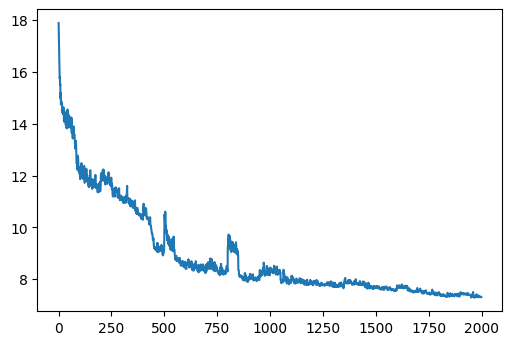

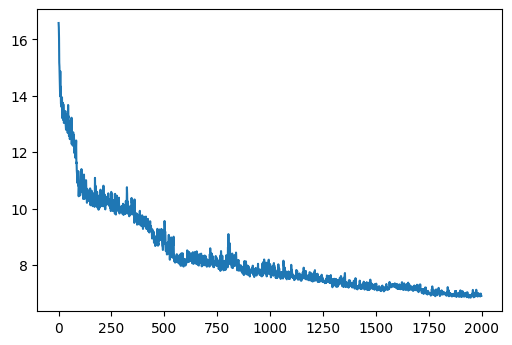

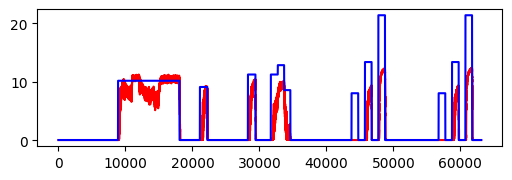

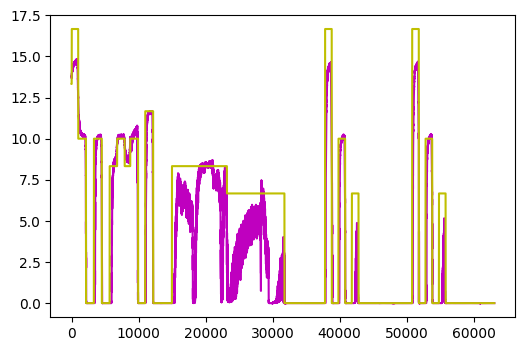

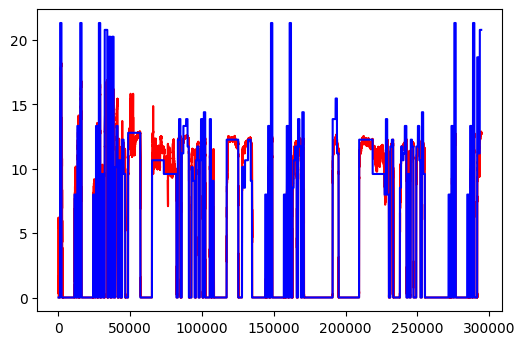

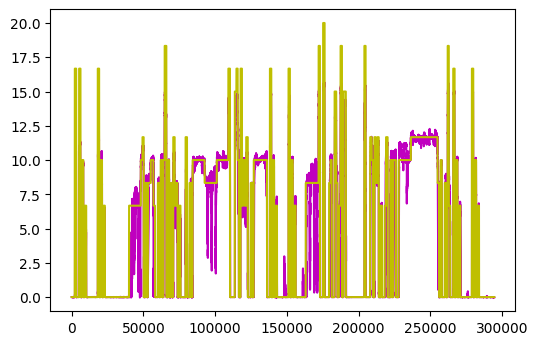

In [0]:
"""
Training session and save the weights.
"""

with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    
    variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
    sess.run(tf.global_variables_initializer())
    new_savers = tf.train.Saver(variables[:8])
    new_saver = tf.train.Saver(variables)
    epoch_list_train=[]
    epoch_list_valid=[]
    train_loss_list=[]
    Validation_loss_list=[]
    Validation_loss_value=[]
    recover_save_path = '/content/ACNNsp_checkpoint.ckpt'
    save_path = "./ANNsp_checkpoint.ckpt"
    
    print("Begin training...")
    # new_savers.restore(sess,recover_save_path)
    sess.run(tf.variables_initializer(variables[-16:]))
    Best_loss = sess.run(Loss_validation,feed_dict={conv1d._inputs:X_data_valid,y:y_valid})
    for epoch in range(Total_epoch):
        start = 0
        end = Batch        
        Loss_value = 0.
        
        if epoch %50==0:
            Inter = np.random.randint(400,high=500)
            Time_interval = np.random.randint(600,high=800)
            X_train = np.random.randn( (X_data_train.shape[0]-Time_interval)//Inter+1,
                      Time_interval,X_data_train.shape[1])
            
            y_train = np.zeros(( (X_data_train.shape[0]-Time_interval)//Inter+1,
                      Time_interval,y_data_train.shape[1]))

            for i in range((X_data_train.shape[0]-Time_interval)//Inter+1):
                X_train[i,:,:] = X_train[i,:,:]*np.random.randn(1)*0.2+ X_data_train[i*Inter:i*Inter+Time_interval,:]
                y_train[i,:,:] =  y_data_train[i*Inter:i*Inter+Time_interval,:]

            Total_chunk = (X_data_train.shape[0]-Time_interval)//Inter+1    
        
        for i in range(int(Total_chunk/Batch)+1):
            if end>Total_chunk:
                X = X_train[start:]
                Y = y_train[start:]
            else:
                X = X_train[start:end]
                Y = y_train[start:end]
                start = end
                end = start+Batch
            _,Loss_local=sess.run([train_step,Loss],feed_dict={conv1d._inputs:X,y:Y})
            Loss_value +=Loss_local
        Loss_value = Loss_value/(int(Total_chunk/Batch)+1.)       
        epoch_list_train.append(epoch)                                      
        train_loss_list.append(Loss_value) 
        
        Validation_loss_value=sess.run(Loss_validation,feed_dict={conv1d._inputs:X_data_valid,y:y_valid})
        Validation_loss_list.append(Validation_loss_value)
        if Validation_loss_value<Best_loss:
            new_saver.save(sess,save_path)
            print("Save new weights!, In this case:")
            print(epoch," ","Loss_train=",Loss_value," ","Validation_loss=",Validation_loss_value)
            Best_loss = Validation_loss_value
        # Validation_loss_value will be computed in every epoch.                     


    
    plt.figure(dpi=100)
    plt.plot(epoch_list_train,train_loss_list,label='Training loss')
    plt.show
    
    plt.figure(dpi=100)
    plt.plot(epoch_list_train,Validation_loss_list,label='Training loss')
    plt.show
    
    new_saver.restore(sess,save_path)
    #X_data_2 = np.reshape(X_data_train,(1,X_data_train.shape[0],X_data_train.shape[1]))        
    Prediction=sess.run(outputs,feed_dict={conv1d._inputs:X_data_test})
    Prediction = np.reshape(Prediction,(Prediction.shape[1],Prediction.shape[2]))
    nx = 2
    ny = 1
    plt.figure(dpi=100)      
    plt.subplot(nx, ny, 1)
    plt.plot(Prediction[:,0], 'r',label='CO estimation (Prediction)')
    plt.plot(y_test[:,0], 'b',label='CO setpoint (Prediction)')
    plt.savefig(fname="CO_ANN_Prediction",format="png")

    plt.show() 
    
    plt.figure(dpi=100)    
    plt.plot(Prediction[:,1], 'm',label='Ethylene estimation (Prediction)')
    plt.plot(y_test[:,1], 'y',label='Ethylene setpoint (Prediction)')
    plt.savefig(fname="Ethy_ANN_Prediction",format="png")

    plt.show() 
    
    train_output=sess.run(outputs,feed_dict={conv1d._inputs:X_data_train_final})
    train_output = np.reshape(train_output,(train_output.shape[1],train_output.shape[2]))
    nx = 2
    ny = 1
    plt.figure(dpi=100)
    plt.plot(train_output[:,0], 'r',label='CO estimation (Training data)')
    plt.plot(y_data_train[:,0], 'b',label='CO setpoint (Training data)')

    plt.show()
    plt.figure(dpi=100)
    plt.plot(train_output[:,1], 'm',label='Ethylene estimation (Training data)')
    plt.plot(y_data_train[:,1], 'y',label='Ethylene setpoint (Training data)')

    plt.show() 

In [0]:
# compute RMSE
CO_pred = Prediction[:, 0]
CO_test = y_test[:, 0]
CO_rms = np.sqrt(np.average(np.square(CO_pred - CO_test)))
print('The root mean square for CO gas is', CO_rms)

ethy_pred = Prediction[:, 1]
ethy_test = y_test[:, 1]
ethy_rms = np.sqrt(np.average(np.square(ethy_pred - ethy_test)))
print('The root mean square for ethylene gas is', ethy_rms)

The root mean square for CO gas is 5.139982712079681
The root mean square for ethylene gas is 3.5358279526325127


Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0

INFO:tensorflow:Restoring parameters from ./ANNsp_checkpoint.ckpt


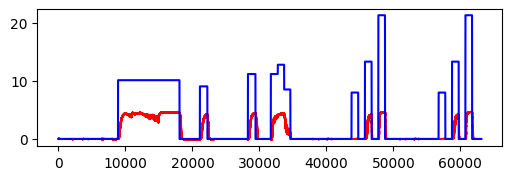

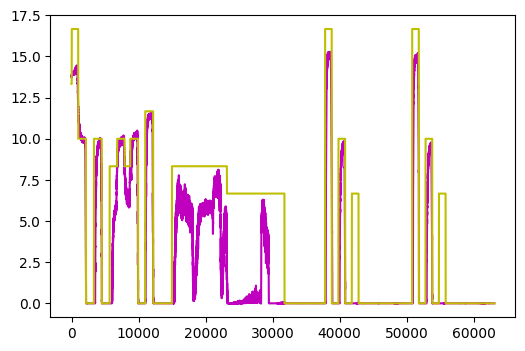

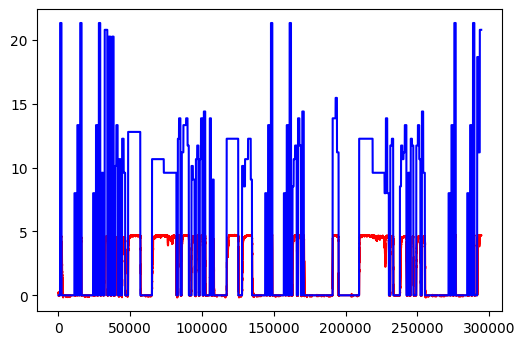

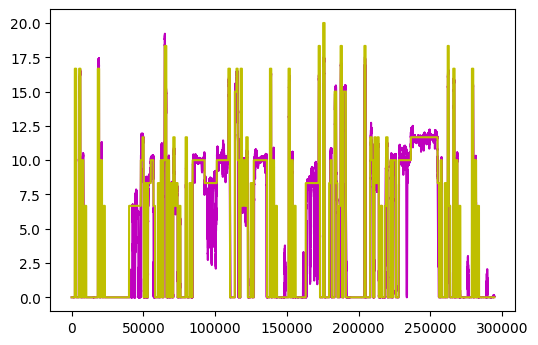

In [0]:
#If you interrupt the training, you can run the code below to plot the results you saved to checkpoints.
with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    new_saver.restore(sess,save_path)
    #X_data_2 = np.reshape(X_data_train,(1,X_data_train.shape[0],X_data_train.shape[1]))        
    Prediction=sess.run(outputs,feed_dict={conv1d._inputs:X_data_test})
    Prediction = np.reshape(Prediction,(Prediction.shape[1],Prediction.shape[2]))
    nx = 2
    ny = 1
    plt.figure(dpi=100)      
    plt.subplot(nx, ny, 1)
    plt.plot(Prediction[:,0], 'r',label='CO estimation (Prediction)')
    plt.plot(y_test[:,0], 'b',label='CO setpoint (Prediction)')

    plt.show() 
    
    plt.figure(dpi=100)    
    plt.plot(Prediction[:,1], 'm',label='Ethylene estimation (Prediction)')
    plt.plot(y_test[:,1], 'y',label='Ethylene setpoint (Prediction)')

    plt.show() 
    
    train_output=sess.run(outputs,feed_dict={conv1d._inputs:X_data_train_final})
    train_output = np.reshape(train_output,(train_output.shape[1],train_output.shape[2]))
    nx = 2
    ny = 1
    plt.figure(dpi=100)
    plt.plot(train_output[:,0], 'r',label='CO estimation (Training data)')
    plt.plot(y_data_train[:,0], 'b',label='CO setpoint (Training data)')

    plt.show()
    plt.figure(dpi=100)
    plt.plot(train_output[:,1], 'm',label='Ethylene estimation (Training data)')
    plt.plot(y_data_train[:,1], 'y',label='Ethylene setpoint (Training data)')

    plt.show() 

In [0]:
np.save("ANNsp_loss_data.npy",[epoch_list_train,train_loss_list,Validation_loss_list])